In [2]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
from matplotlib import pyplot
plt.style.use('fivethirtyeight')

In [3]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [4]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

cal = calendar()

In [15]:
data = pd.read_csv('PJM_Load_hourly.csv', index_col=[0], parse_dates=[0])

In [16]:
data = data.sort_index()

In [17]:
#data['PJM_Load_MW_mean_halfday'] = data['PJM_Load_MW'].rolling(12).mean()
data['PJM_Load_MW_mean_daily'] = data['PJM_Load_MW'].rolling(24).mean()
data['PJM_Load_MW_mean_weekly'] = data['PJM_Load_MW'].rolling(24*7).mean()
data['PJM_Load_MW_mean_monthly'] = data['PJM_Load_MW'].rolling(24*30).mean()

In [18]:
#data['PJM_Load_MW_std_halfday'] = data['PJM_Load_MW'].rolling(12).mean()
data['PJM_Load_MW_std_daily'] = data['PJM_Load_MW'].rolling(24).std()
data['PJM_Load_MW_std_weekly'] = data['PJM_Load_MW'].rolling(24*7).std()
data['PJM_Load_MW_std_monthly'] = data['PJM_Load_MW'].rolling(24*30).std()

In [19]:
data['date'] = data.index
data['hour'] = data['date'].dt.hour
data['dayofweek'] = data['date'].dt.dayofweek
#data['quarter'] = data['date'].dt.quarter
data['month'] = data['date'].dt.month
data['year'] = data['date'].dt.year 
data['dayofyear'] = data['date'].dt.dayofyear
data['dayofmonth'] = data['date'].dt.day
data['weekofyear'] = data['date'].dt.weekofyear
#data['day_night'] = data['date'].dt.strftime('%B %d, %Y, %r').str[-2:]
#data['is_holiday'] = data['date'].isin([d.date() for d in cal.holidays()])

In [20]:
data = data.drop(columns=['date'])

In [24]:
data.head(10)

,PJM_Load_MW,PJM_Load_MW_mean_daily,PJM_Load_MW_mean_weekly,PJM_Load_MW_mean_monthly,PJM_Load_MW_std_daily,PJM_Load_MW_std_weekly,PJM_Load_MW_std_monthly,hour,dayofweek,month,year,dayofyear,dayofmonth,weekofyear,target
Datetime,,,,,,,,,,,,,,,
1998-04-01 01:00:00,22259.0,NaN,NaN,NaN,NaN,NaN,NaN,1,2,4,1998,91,1,14,22526.0
1998-04-01 02:00:00,21244.0,NaN,NaN,NaN,NaN,NaN,NaN,2,2,4,1998,91,1,14,25772.0
1998-04-01 03:00:00,20651.0,NaN,NaN,NaN,NaN,NaN,NaN,3,2,4,1998,91,1,14,28724.0
1998-04-01 04:00:00,20421.0,NaN,NaN,NaN,NaN,NaN,NaN,4,2,4,1998,91,1,14,30075.0
1998-04-01 05:00:00,20713.0,NaN,NaN,NaN,NaN,NaN,NaN,5,2,4,1998,91,1,14,30689.0
1998-04-01 06:00:00,22526.0,NaN,NaN,NaN,NaN,NaN,NaN,6,2,4,1998,91,1,14,31295.0
1998-04-01 07:00:00,25772.0,NaN,NaN,NaN,NaN,NaN,NaN,7,2,4,1998,91,1,14,31539.0
1998-04-01 08:00:00,28724.0,NaN,NaN,NaN,NaN,NaN,NaN,8,2,4,1998,91,1,14,31227.0
1998-04-01 09:00:00,30075.0,NaN,NaN,NaN,NaN,NaN,NaN,9,2,4,1998,91,1,14,31235.0


In [22]:
data['target'] = data['PJM_Load_MW'].shift(-5)

In [23]:
data

,PJM_Load_MW,PJM_Load_MW_mean_daily,PJM_Load_MW_mean_weekly,PJM_Load_MW_mean_monthly,PJM_Load_MW_std_daily,PJM_Load_MW_std_weekly,PJM_Load_MW_std_monthly,hour,dayofweek,month,year,dayofyear,dayofmonth,weekofyear,target
Datetime,,,,,,,,,,,,,,,
1998-04-01 01:00:00,22259.0,NaN,NaN,NaN,NaN,NaN,NaN,1,2,4,1998,91,1,14,22526.0
1998-04-01 02:00:00,21244.0,NaN,NaN,NaN,NaN,NaN,NaN,2,2,4,1998,91,1,14,25772.0
1998-04-01 03:00:00,20651.0,NaN,NaN,NaN,NaN,NaN,NaN,3,2,4,1998,91,1,14,28724.0
1998-04-01 04:00:00,20421.0,NaN,NaN,NaN,NaN,NaN,NaN,4,2,4,1998,91,1,14,30075.0
1998-04-01 05:00:00,20713.0,NaN,NaN,NaN,NaN,NaN,NaN,5,2,4,1998,91,1,14,30689.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2001-12-31 20:00:00,36392.0,32718.750000,31029.851190,29640.298611,3009.060178,3648.132180,4121.390260,20,0,12,2001,365,31,1,NaN
2001-12-31 21:00:00,35082.0,32681.583333,31055.065476,29649.791667,2972.389888,3661.468182,4126.045636,21,0,12,2001,365,31,1,NaN
2001-12-31 22:00:00,33890.0,32636.208333,31074.839286,29659.000000,2943.970049,3667.786829,4128.102546,22,0,12,2001,365,31,1,NaN


In [13]:
data.dropna(axis=0, how='any', inplace=True)

In [314]:
X_train = data_train.drop(columns=['target','year','month'])
X_test = data_test.drop(columns=['target','year','month'])
y_train = data_train[['target']]
y_test = data_test[['target']]

In [353]:
reg = xgb.XGBRegressor(n_estimators=100)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=True) # Change verbose to True if you want to see it train

[0]	validation_0-rmse:21128.38672	validation_1-rmse:21657.93750
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:14882.31836	validation_1-rmse:15330.00977
[2]	validation_0-rmse:10519.58789	validation_1-rmse:10902.10644
[3]	validation_0-rmse:7486.73584	validation_1-rmse:7841.66943
[4]	validation_0-rmse:5385.09522	validation_1-rmse:5720.71484
[5]	validation_0-rmse:3952.22314	validation_1-rmse:4279.01270
[6]	validation_0-rmse:2986.51294	validation_1-rmse:3314.32812
[7]	validation_0-rmse:2333.27759	validation_1-rmse:2671.89624
[8]	validation_0-rmse:1923.21912	validation_1-rmse:2285.82910
[9]	validation_0-rmse:1643.71753	validation_1-rmse:2013.79102
[10]	validation_0-rmse:1471.96326	validation_1-rmse:1856.53967
[11]	validation_0-rmse:1371.80579	validation_1-rmse:1769.30798
[12]	validation_0-rmse:1307.07654	validation_1-rmse:1727.25378
[13]	validation_0-rmse:125

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [375]:
pyplot.rcParams["figure.figsize"] = (20,10)

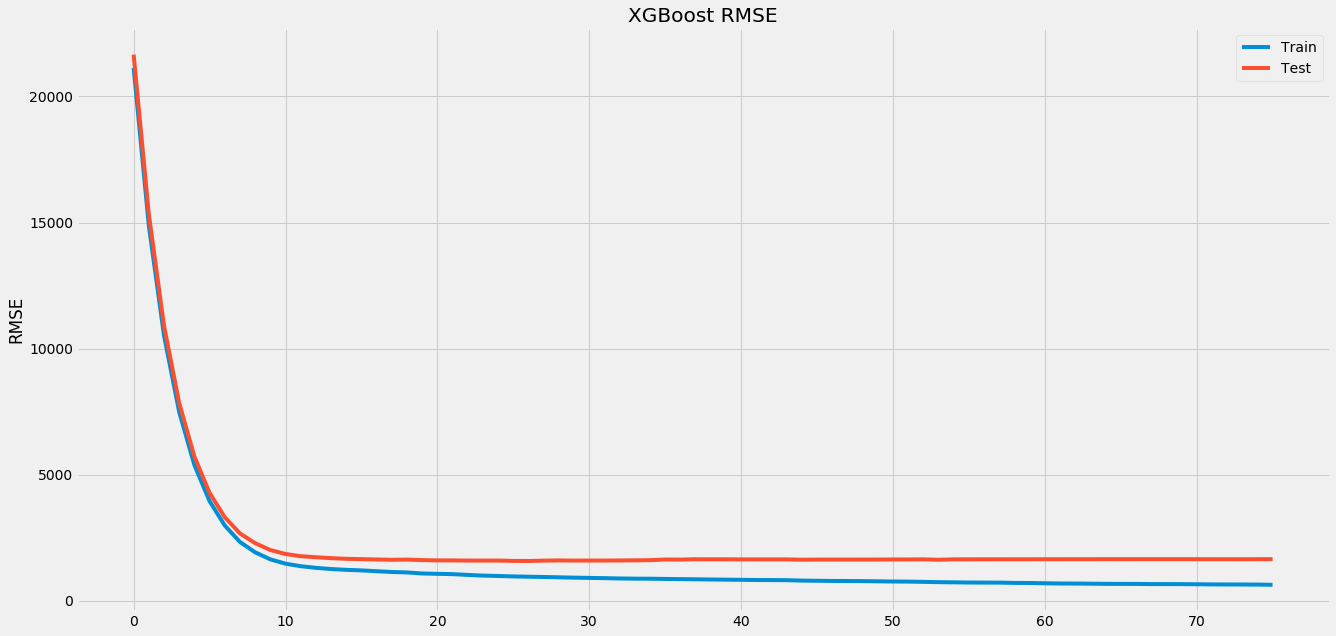

In [377]:
# retrieve performance metrics
results = reg.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)
# plot rmse
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
ax.plot(x_axis, results['validation_1']['rmse'], label='Test')
ax.legend()
pyplot.ylabel('RMSE')
pyplot.title('XGBoost RMSE')
pyplot.show()

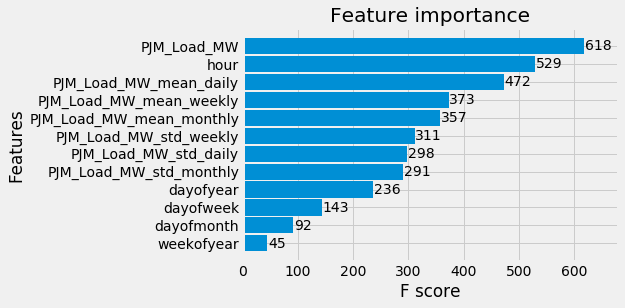

In [361]:
_ = plot_importance(reg, height=0.9)

In [362]:
data_test['MW_Prediction'] = reg.predict(X_test)
data_all = pd.concat([data_test, data_train], sort=False)

In [363]:
#persistance error

In [364]:
mean_squared_error(y_true=data_test['PJM_Load_MW'],y_pred=data_test['MW_Prediction'])

30483866.3359838

In [365]:
mean_absolute_error(y_true=data_test['PJM_Load_MW'],y_pred=data_test['MW_Prediction'])

4422.525243687354

In [366]:
mean_absolute_percentage_error(y_true=data_test['PJM_Load_MW'],y_pred=data_test['MW_Prediction'])

15.278173582442106

In [367]:
#predictions error 

In [368]:
mean_squared_error(y_true=data_test['target'],y_pred=data_test['MW_Prediction'])

2491663.953385091

In [369]:
mean_absolute_error(y_true=data_test['target'],y_pred=data_test['MW_Prediction'])

1136.50991434236

In [370]:
mean_absolute_percentage_error(y_true=data_test['target'],y_pred=data_test['MW_Prediction'])

3.6739215849622164

In [371]:
data_test['error'] = data_test['target'] - data_test['MW_Prediction']
data_test['abs_error'] = data_test['error'].apply(np.abs)
error_by_day = data_test.groupby(['year','month','dayofmonth']) \
    .mean()[['target','MW_Prediction','error','abs_error']]

In [372]:
# Over forecasted days
error_by_day.sort_values('error', ascending=True).head(20)

target  MW_Prediction        error    abs_error
year month dayofmonth                                                       
2000 6     3           26445.041667   30750.351562 -4305.309408  4305.309408
     7     19          30283.666667   33849.023438 -3565.357422  3739.976074
2001 9     1           29106.958333   31989.212891 -2882.255290  2888.151449
     11    22          24753.875000   27424.673828 -2670.798747  3370.698649
2000 6     13          29479.541667   31889.751953 -2410.210531  2653.950602
2001 5     28          23556.333333   25943.109375 -2386.775309  2690.066325
2000 5     29          22638.625000   24964.988281 -2326.363851  2716.383382
2001 7     2           28495.166667   30754.753906 -2259.587646  2342.758057
2000 7     11          34255.208333   36433.316406 -2178.106364  2202.956136
     6     12          35993.958333   38139.695312 -2145.736979  2230.886719
2001 5     5           26445.666667   28524.898438 -2079.232503  2096.452393
     7     1           33254.833333   35273.339844 -2018.506348  2084.930013
2000 11    23          28447.416667   30347.671875 -1900.255127  3475.260498
     5     15          27046.666667   28861.564453 -1814.897624  1909.538249
2001 7     18          34885.083333   36681.597656 -1796.515137  1916.589518
     9     2           24748.375000   26522.533203 -1774.158854  1774.158854
     12    24          27784.708333   29517.060547 -1732.352865  2543.485026
     9     5           31508.666667   33220.621094 -1711.955160  1753.534261
2000 5     10          31256.083333   32933.183594 -1677.099365  1852.146891
2001 9     25          29115.750000   30758.667969 -1642.918864  1768.918538

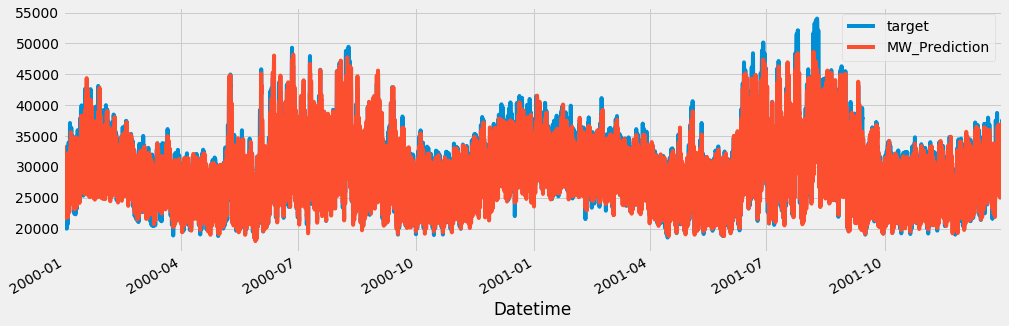

In [357]:
_ = data_test[['target','MW_Prediction']].plot(figsize=(15, 5))

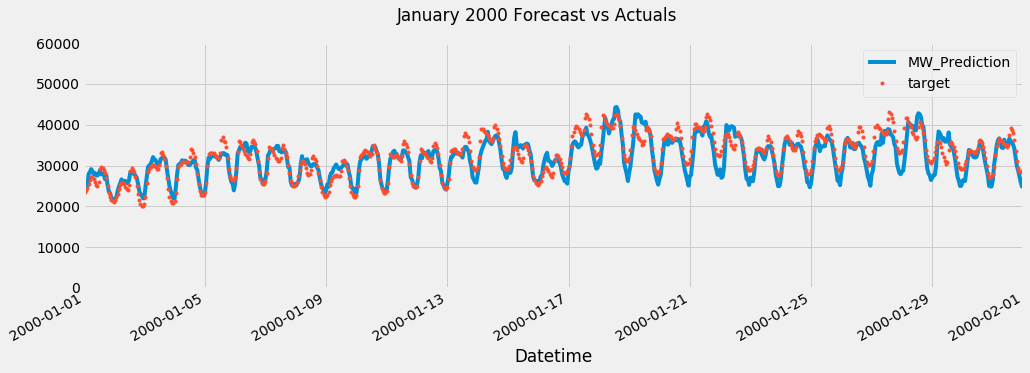

In [358]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = data_test[['MW_Prediction','target']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='01-01-2000', upper='02-01-2000')
ax.set_ylim(0, 60000)
plot = plt.suptitle('January 2000 Forecast vs Actuals')

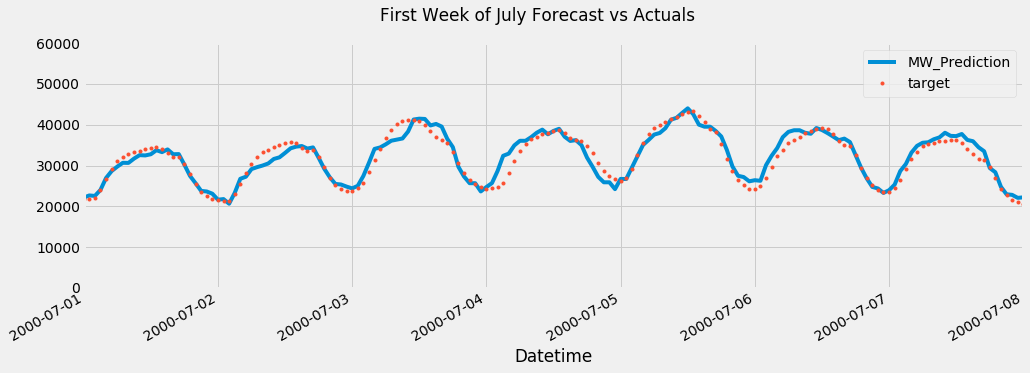

In [359]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = data_test[['MW_Prediction','target']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='07-01-2000', upper='07-08-2000')
plot = plt.suptitle('First Week of July Forecast vs Actuals')